<a href="https://colab.research.google.com/github/Morfinic/PWR_1_st.2_UM/blob/master/P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pimg
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers, Sequential
from IPython.display import Image

Poniższy blok pobiera dataset z Kaggle. Po uruchomieniu możliwe jest wybranie pliku, który posłuży jako klucz dostępu (Konto Kaggle -> Ustawienia -> API/Create new token).

**Datasets**
* https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
* https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images


In [2]:
from google.colab import files
%cd /content
files.upload()

kaggle_path = "cashbowman/ai-generated-images-vs-real-images"

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d $kaggle_path

import zipfile
zip_ref = zipfile.ZipFile(kaggle_path.split('/')[-1] + '.zip', 'r')
zip_ref.extractall('/content/kaggle')
zip_ref.close()

/content


Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images
License(s): Community Data License Agreement - Sharing - Version 1.0


In [3]:
print("Devices: ", tf.config.list_physical_devices())

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [23]:
datasetPath = "/content/kaggle"

imgDim = (500, 500)
batchSize = 10

dataset = tf.keras.utils.image_dataset_from_directory(
    datasetPath,
    label_mode='binary',
    seed=500,
    image_size=imgDim,
    batch_size=batchSize,
    shuffle=True
)

trainingSetSize = 0.8
validationgSetSize = 0.1

datasetSize = len(dataset)
trainBatches = int(datasetSize * trainingSetSize) + 1
validationBatches = int(datasetSize * validationgSetSize)
testingBatches = datasetSize - trainBatches - validationBatches

trainingSet = dataset.take(trainBatches)
validationSet = dataset.skip(trainBatches).take(validationBatches)
testingSet = dataset.skip(trainBatches + validationBatches)

trainingSet = trainingSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validationSet = validationSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
testingSet = testingSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Training set lenght:", len(trainingSet))
print("Validation set lenght:", len(validationSet))
print("Testing set lenght:", len(testingSet))
print("Training classes: ", dataset.class_names)



Found 971 files belonging to 2 classes.
Training set lenght: 79
Validation set lenght: 9
Testing set lenght: 10
Training classes:  ['AiArtData', 'RealArt']


In [5]:
def plotMetrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

classNames = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

---
# VGG16
---

In [24]:
# VGG16_base = tf.keras.applications.VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(*imgDim, 3),
#     pooling="avg"
# )

# VGG16_base.trainable = False

EffNetV2_base = tf.keras.applications.EfficientNetV2B3(
    weights='imagenet',
    input_shape=(*imgDim, 3),
    include_top=False,
    pooling='max'
)

input = tf.keras.Input(shape=(*imgDim, 3))

data_aug = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1)
])

x = data_aug(input)

# x = VGG16_base(x, training=False)
x = EffNetV2_base(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True
)(x)
x = Dense(
    256,
    activation="relu",
    kernel_regularizer=regularizers.l2(0.001),
    bias_regularizer=regularizers.l2(0.001),
    activity_regularizer=regularizers.l1(0.001)
)(x)
x = Dropout(
    rate = .4,
    seed = 500
)(x)
x = Dense(
    256,
    activation="relu"
)(x)
x = Dropout(
    rate = .4,
    seed = 500
)(x)
x = Dense(
    64,
    activation="relu"
)(x)
output = Dense(1, activation="sigmoid")(x)

VGG16_model = tf.keras.Model(input, output)

VGG16_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

VGG16_model.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 500, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 500, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 1536)           │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,412,543 (51.16 MB)

 Trainable params: 13,300,255 (50.74 MB)

 Non-trainable params: 112,288 (438.62 KB)

In [ ]:
print("Starting training at", datetime.now())
VGG16_history = VGG16_model.fit(
    trainingSet,
    validation_data = validationSet,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Finished trainging at", datetime.now())
VGG16_model.save("VGG16-1-gen.keras")
print("Saved trained model")

Starting training at 2025-05-05 08:26:09.345352
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.5685 - loss: 2.4384 - precision_2: 0.4985 - recall_2: 0.4831 - val_accuracy: 0.8222 - val_loss: 2.0670 - val_precision_2: 0.8200 - val_recall_2: 0.8542
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 708ms/step - accuracy: 0.7518 - loss: 1.4399 - precision_2: 0.6979 - recall_2: 0.7587 - val_accuracy: 0.7556 - val_loss: 1.2677 - val_precision_2: 0.7031 - val_recall_2: 0.9375
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 700ms/step - accuracy: 0.6945 - loss: 1.2055 - precision_2: 0.6483 - recall_2: 0.6533 - val_accuracy: 0.7778 - val_loss: 1.1180 - val_precision_2: 0.7121 - val_recall_2: 0.9792
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 703ms/step - accuracy: 0.7405 - loss: 1.0951 - precision_2: 0.6883 - recall_2: 0.7373 - val_accuracy: 0.7444 - val_loss: 1.0838 - val_precision_2: 0.6812 - val_recall_2: 0.9792
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 702ms/step - accuracy: 0.7285 -

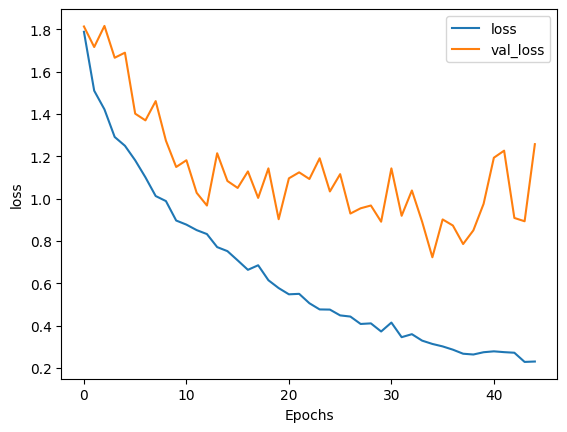

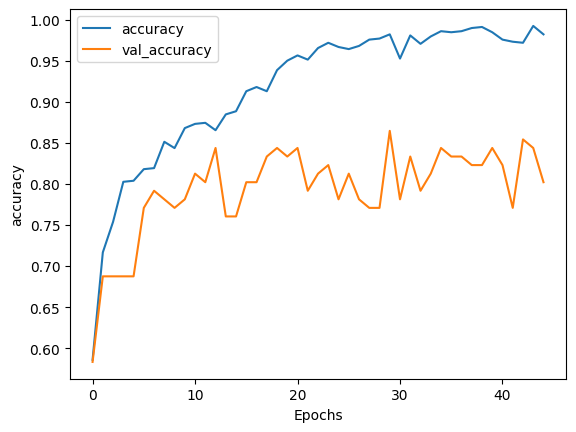

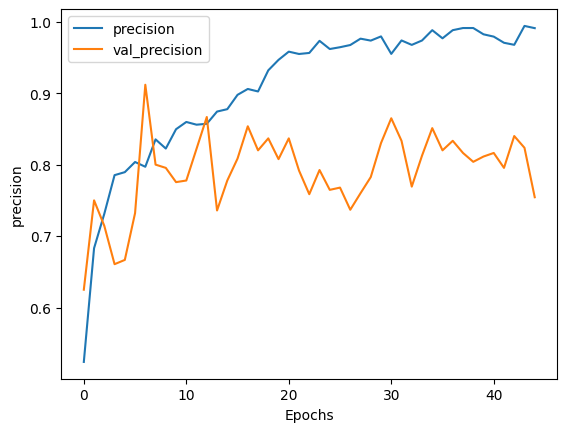

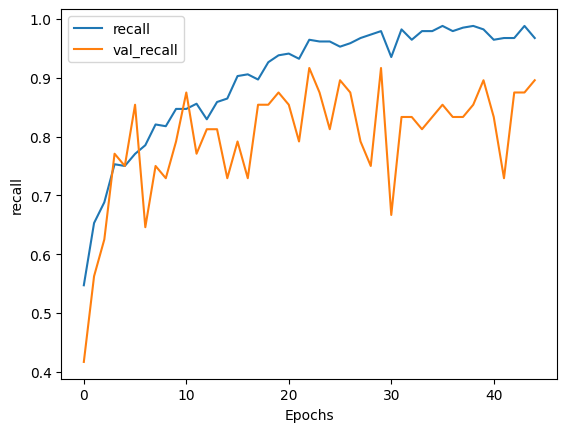

In [9]:
plotMetrics(VGG16_history, "loss")
plotMetrics(VGG16_history, "accuracy")
plotMetrics(VGG16_history, "precision")
plotMetrics(VGG16_history, "recall")

---
# Testing
---

In [18]:
%cd /content
loadedModel = tf.keras.models.load_model("VGG16-1-gen.keras")

/content


In [19]:
val_loss, val_accuracy, val_precision, val_recall = loadedModel.evaluate(testingSet)

print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8234 - loss: 1.1483 - precision: 0.8794 - recall: 0.7727
Loss: 1.0580
Accuracy: 0.8316
Precision: 0.8837
Recall: 0.7755


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


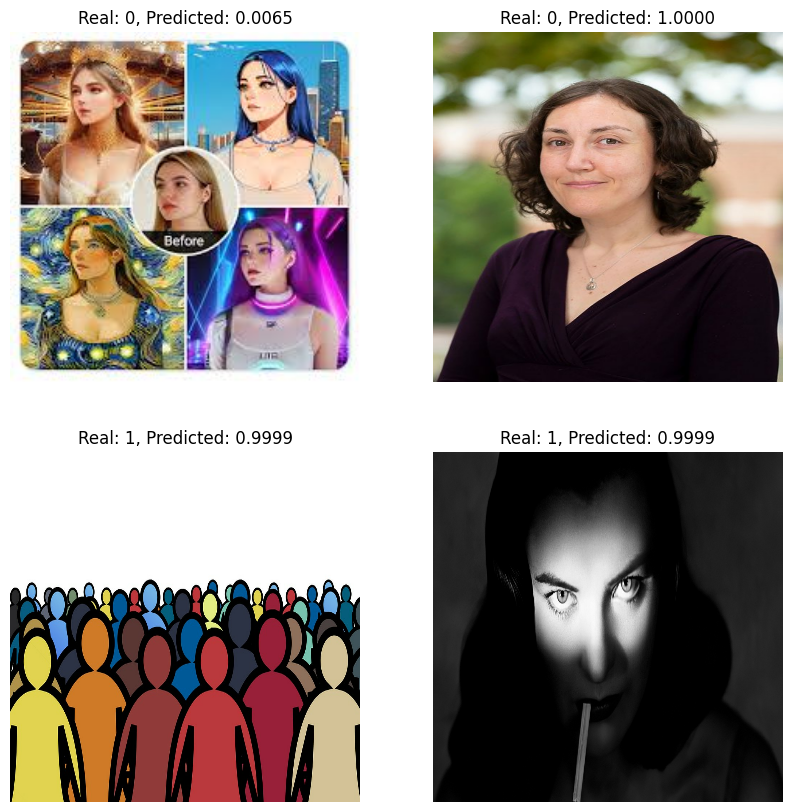

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in trainingSet.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        result = loadedModel.predict(np.expand_dims(np.array(images[i]), axis = 0))
        plt.title(f"Real: {int(labels[i])}, Predicted: {result[0 ,0]:.4f}")
        plt.axis("off")

mkdir: cannot create directory ‘/content/imgTest’: File exists
/content/imgTest


Saving images.jpg to images.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


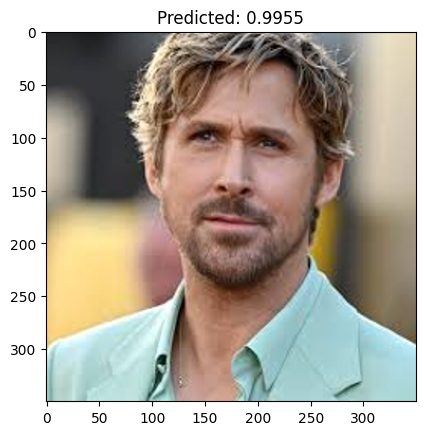

In [15]:
!mkdir /content/imgTest
%cd /content/imgTest
uploaded = files.upload()
uploadName = list(uploaded.keys())[0]

with pimg.open(uploadName) as img:
  res = img.resize(imgDim).convert('RGB')
  result = loadedModel.predict(np.expand_dims(np.array(res), axis = 0))
  plt.title(f"Predicted: {result[0 ,0]:.4f}")
  imgplot = plt.imshow(res)
  plt.show()